In [18]:

# !pip install pandas numpy seaborn matplotlib genshim sklearn

# !pip install kagglehub underthesea tqdm
# !pip install transformer touch re wordcloud

# !pip install googletrans==4.0.0-rc1


# Resources

- **NLTK Parser (Vietnamese Tokenization):** [Underthesea Documentation](https://underthesea.readthedocs.io/en/latest/readme.html)  
- **Corpus Dataset:** [Pham Tuyet - Vietnamese Text Classification Dataset on Kaggle](https://www.kaggle.com/datasets/phamtuyet/text-classification?select=text_tokenizer.xlsx)  
- **Stopword Dataset:** [L3VIEVIL - Vietnamese Stopwords on Kaggle](https://www.kaggle.com/datasets/linhlpv/vietnamese-stopwords)


# Vietnamese Text Processing: Lemmatization and Tokenization

### Why Vietnamese doesn't need lemmatization
asd
Unlike languages such as English, where words can have multiple inflected forms (e.g., *run, runs, running, ran*), Vietnamese words typically **remain in their root form** regardless of tense, number, or gender.  

This is because Vietnamese is an **analytic language**, where grammatical relationships are expressed using separate function words or word order rather than inflection.  

**Example:**  

| Vietnamese | English |
|------------|---------|
| ăn        | eat     |
| ăn         | ate     |
| ăn        | eating  |

Here, the word `ăn` does not change form. Therefore, **lemmatization is generally unnecessary**, and we can work directly with the raw word tokens for text analysis.

---

### How Vietnamese tokenization works

In Vietnamese, **words are usually made up of one or more syllables separated by spaces**, which means naive whitespace splitting will often split a single word into multiple tokens. Therefore, proper tokenization is needed to identify **multi-syllable words** as single units.

We use [**underthesea**](https://underthesea.readthedocs.io/en/latest/api.html#word-tokenize)  for tokenization.  

**Example:**
```python
from underthesea import word_tokenize
sentence = "Bác sĩ bây giờ có thể thản nhiên báo tin bệnh nhân bị ung thư"
# "Doctors can now calmly deliver the news that a patient has cancer."


tokenized = word_tokenize(sentence, format="text")
# tokenized = "Bác_sĩ bây_giờ có_thể thản_nhiên báo_tin bệnh_nhân bị ung_thư"


In [19]:
# Core Imports 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
import warnings
import time

import kagglehub
from underthesea import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from googletrans import Translator
from tqdm.auto import tqdm
import warnings
from wordcloud import WordCloud

# Ignore all warnings
warnings.filterwarnings("ignore")


# Optional Google Translator
translator = None
try:
    from googletrans import Translator
    translator = Translator()
    print("Google Translator initialized.")
except ImportError:
    print("googletrans not installed, skipping translation.")
except Exception as e:
    print(f"Could not initialize translator: {e}")

warnings.simplefilter("ignore")  
tqdm.pandas(desc="Processing")   

# Define folders for saving results
PKL_FOLDER = 'pkl_folder'
DATA_FOLDER = 'data'

os.makedirs(PKL_FOLDER, exist_ok=True)
os.makedirs(DATA_FOLDER, exist_ok=True)
print(f"Folders ready: PKL -> {PKL_FOLDER}, DATA -> {DATA_FOLDER}")






def translate_words(words_list):
    translations = []
    if not translator: 
        return ["N/A"] * len(words_list)

    for word in words_list:
        for attempt in range(3):  # retry up to 3 times
            try:
                translated = translator.translate(word, src='vi', dest='en')
                translations.append(translated.text if hasattr(translated, 'text') else "N/A")
                break
            except Exception:
                if attempt < 2:
                    time.sleep(0.8)  # wait before retrying
                else:
                    translations.append("Error")
    return translations


print("Helper function 'translate_words' is defined.")




Google Translator initialized.
Folders ready: PKL -> pkl_folder, DATA -> data
Helper function 'translate_words' is defined.


In [20]:

DATASET_NAME = 'phamtuyet/text-classification'
EXCEL_FILE = 'text.xlsx'
N_SAMPLES_PER_CATEGORY = 2000  # Number of samples per category

# Define the English mapping before loading the data
LABEL_MAPPING = {
    'chinh-tri': 'Politics',
    'doi-song': 'Daily_Life',
    'giao-duc': 'Education',
    'kinh-doanh': 'Business',
    'phap-luat': 'Law',
    'suc-khoe': 'Health',
    'the-gioi': 'World',
    'the-thao': 'Sports'
}




In [21]:

import re

TOKENIZED_FILE = os.path.join(DATA_FOLDER, 'vn_news_tokenized.pkl')

# Preprocessing function
def preprocess_vn_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"\d+", "", text)                 # Remove numbers
    text = re.sub(r"[^\w\s_]", "", text)            # Remove punctuation except _
    text = re.sub(r"\s+", " ", text).strip()        # Remove extra whitespace
    tokenized_text = word_tokenize(text)
    return tokenized_text

# If tokenized version exists, load it
if os.path.exists(TOKENIZED_FILE):
    print(f"Loading tokenized dataset from: {TOKENIZED_FILE}")
    vn_df = pd.read_pickle(TOKENIZED_FILE)
    print("Tokenized dataset loaded successfully!")
    
else:
    vn_df = None 

    # Download or locate dataset
    try:
        news_dataset_path = kagglehub.dataset_download(DATASET_NAME)
        print(f"Dataset downloaded/located via KaggleHub: {news_dataset_path}")
    except Exception as e:
        print(f"Error downloading/finding dataset: {e}")
        news_dataset_path = None

    # Load Excel file if available
    if news_dataset_path and os.path.exists(os.path.join(news_dataset_path, EXCEL_FILE)):
        file_path = os.path.join(news_dataset_path, EXCEL_FILE)
        print(f"Loading dataset from: {file_path}")
        
        full_news_df = pd.read_excel(file_path, header=None, names=['content', 'label'])
        
        full_news_df = full_news_df[full_news_df['label'] != 'label'].copy()
        
        # Create subset
        vn_df_news_subset = full_news_df.groupby('label', group_keys=False).apply(
            lambda x: x.sample(min(len(x), N_SAMPLES_PER_CATEGORY), random_state=42)
        )
        
        vn_df = vn_df_news_subset.reset_index(drop=True)

        # Apply English label mapping 
        vn_df['label'] = vn_df['label'].map(LABEL_MAPPING)
        
        print(f"Subset created successfully! Total rows: {len(vn_df)}, Categories: {vn_df['label'].nunique()}")
        print("\nCategory distribution:")
        print(vn_df['label'].value_counts())
    else:
        print("Error: Could not locate the dataset file. Check the path or KaggleHub download.")


    print("Preprocessing and tokenizing Vietnamese news content...")
    vn_df['clean_content'] = vn_df['content'].progress_apply(preprocess_vn_text)
    print("Preprocessing completed!")

    # Save tokenized version for future runs
    vn_df.to_pickle(TOKENIZED_FILE)
    print(f"Tokenized dataset saved to: {TOKENIZED_FILE}")

# Quick check
print(vn_df[['content', 'clean_content']].head(3))


Loading tokenized dataset from: data\vn_news_tokenized.pkl
Tokenized dataset loaded successfully!
                                             content  \
0  Hôm nay , Tỉnh ủy Quảng Bình tổ chức hội nghị ...   
1  Từ ngày 29 - 31/5 , tại Hà Nội , UB Kiểm tra T...   
2  Sau 1 tháng , Bộ Nội vụ và Trung ương Đoàn đã ...   

                                       clean_content  
0  hôm_nay tỉnh ủy quảng_bình tổ_chức hội_nghị lầ...  
1  từ ngày tại hà_nội ub kiểm_tra tư đã họp kỳ bí...  
2  sau tháng bộ nội_vụ và trung_ương đoàn đã nhận...  


In [22]:
vn_df

content     label  \
0      Hôm nay , Tỉnh ủy Quảng Bình tổ chức hội nghị ...  Politics   
1      Từ ngày 29 - 31/5 , tại Hà Nội , UB Kiểm tra T...  Politics   
2      Sau 1 tháng , Bộ Nội vụ và Trung ương Đoàn đã ...  Politics   
3      Tham dự và phát biểu gồm Phó Chủ tịch thay mặt...  Politics   
4      Ngày cuối cùng phiên đấu giá quả bóng và áo th...  Politics   
...                                                  ...       ...   
15995  VCK U20 châu Á 2023 là phiên bản thứ 41 của gi...    Sports   
15996  Trong những ngày vừa qua , có rất nhiều thông ...    Sports   
15997  Trước cuộc chạm trán trên sân Thống Nhất , TPH...    Sports   
15998  Bài toán Pogba và Bruno Fernandes MU chuẩn bị ...    Sports   
15999  Trong cuộc trò chuyện với báo chí Hàn Quốc , H...    Sports   

                                           clean_content  
0      hôm_nay tỉnh ủy quảng_bình tổ_chức hội_nghị lầ...  
1      từ ngày tại hà_nội ub kiểm_tra tư đã họp kỳ bí...  
2      sau tháng bộ nội_vụ và trung_ương đoàn đã nhận...  
3      tham_dự và phát_biểu gồm phó chủ_tịch thay_mặt...  
4      ngày cuối_cùng phiên đấu_giá quả bóng và áo th...  
...                                                  ...  
15995  vck u châu_á là phiên_bản thứ của giải bao_gồm...  
15996  trong những ngày vừa_qua có rất nhiều thông_ti...  
15997  trước cuộc chạm_trán trên sân thống_nhất tphcm...  
15998  bài_toán pogba và bruno fernandes_mu chuẩn_bị ...  
15999  trong cuộc trò_chuyện với báo_chí hàn_quốc hlv...  

[16000 rows x 3 columns]

In [23]:
stopwords = []
with open("data/vietnamese-stopwords-dash.txt", "r", encoding="utf-8") as f:
    for line in f:
        word = line.strip()
        if word:  # ignore blank lines
            stopwords.append(word)

print(f"Loaded {len(stopwords)} stopwords")
print(stopwords[:20])  # sample


vietnamese_stopwords_set = set(stopwords)

Loaded 1942 stopwords
['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy', 'ba', 'ba_ba', 'ba_bản', 'ba_cùng', 'ba_họ', 'ba_ngày', 'ba_ngôi', 'ba_tăng', 'bao_giờ', 'bao_lâu']


# Question 1: Estimates Stopword Proportion

In [24]:
TASK1_STATS_PKL = os.path.join(PKL_FOLDER, 'task1.pkl') 

from collections import Counter

# Check if cached file exists
if os.path.exists(TASK1_STATS_PKL):
    print(f"Loading cached Task 1 results from {TASK1_STATS_PKL}...")
    with open(TASK1_STATS_PKL, 'rb') as f:
        data = pickle.load(f)
    stats_df_task1 = data["df"]
    stopword_freq_by_cat = data["stopwords"]
    print("Task 1 results loaded.")
else:
    print(f"Cache not found for Task 1. Running analysis...")

    # Initialize dictionary to store stopword counts per category
    stopword_freq_by_cat = {cat: Counter() for cat in vn_df['label'].unique()}

    # Function to process text and collect stopwords
    def process_text_task1(row):
        text, category = row['content'], row['label']
        tokens = str(text).split(' ')
        stopwords = [t for t in tokens if t in vietnamese_stopwords_set]
        stopword_freq_by_cat[category].update(stopwords)
        return pd.Series({
            'total_tokens': len(tokens),
            'stopword_tokens': len(stopwords)
        })

    print("Tokenizing sentences and collecting stopwords for Task 1...")
    token_counts_df = vn_df.progress_apply(process_text_task1, axis=1)

    # Combine counts with news labels
    CATEGORY_COLUMN = 'label'
    results_df = pd.concat([vn_df[CATEGORY_COLUMN], token_counts_df], axis=1)

    # Aggregate by category
    stats_df_task1 = results_df.groupby(CATEGORY_COLUMN).sum()

    # Calculate proportion
    stats_df_task1['Stopword Proportion (%)'] = (
        stats_df_task1['stopword_tokens'] / stats_df_task1['total_tokens']
    ) * 100

    # Reset index and keep category names
    stats_df_task1 = stats_df_task1.reset_index().rename(columns={CATEGORY_COLUMN: 'Category'})

    # Save results
    print(f"Task 1 analysis complete. Saving results to {TASK1_STATS_PKL}...")
    with open(TASK1_STATS_PKL, 'wb') as f:
        pickle.dump({"df": stats_df_task1, "stopwords": stopword_freq_by_cat}, f)
    print("Task 1 results saved.")

print("\n--- Top 10 Stopwords by Category ---")
for category, counter in stopword_freq_by_cat.items():
    print(f"\nCategory: {category}")
    top_words = [w for w, _ in counter.most_common(10)]
    counts = [c for _, c in counter.most_common(10)]
    translated_words = translate_words(top_words)
    df_display = pd.DataFrame({
        'Stopword (VI)': top_words,
        'Translation (EN)': translated_words,
        'Frequency': counts
    })
    print(df_display.to_markdown(index=False))


Loading cached Task 1 results from pkl_folder\task1.pkl...
Task 1 results loaded.

--- Top 10 Stopwords by Category ---

Category: Politics
| Stopword (VI)   | Translation (EN)   |   Frequency |
|:----------------|:-------------------|------------:|
| và              | and                |       22378 |
| của             | belong to          |       19073 |
| các             | the                |       18226 |
| có              | Have               |       13958 |
| là              | To be              |       11979 |
| trong           | in                 |       11133 |
| với             | with               |       10114 |
| nước            | water              |        9607 |
| cho             | give               |        9159 |
| được            | Okay               |        8981 |

Category: Daily_Life
| Stopword (VI)   | Translation (EN)   |   Frequency |
|:----------------|:-------------------|------------:|
| có              | Have               |       17974 |
| và         

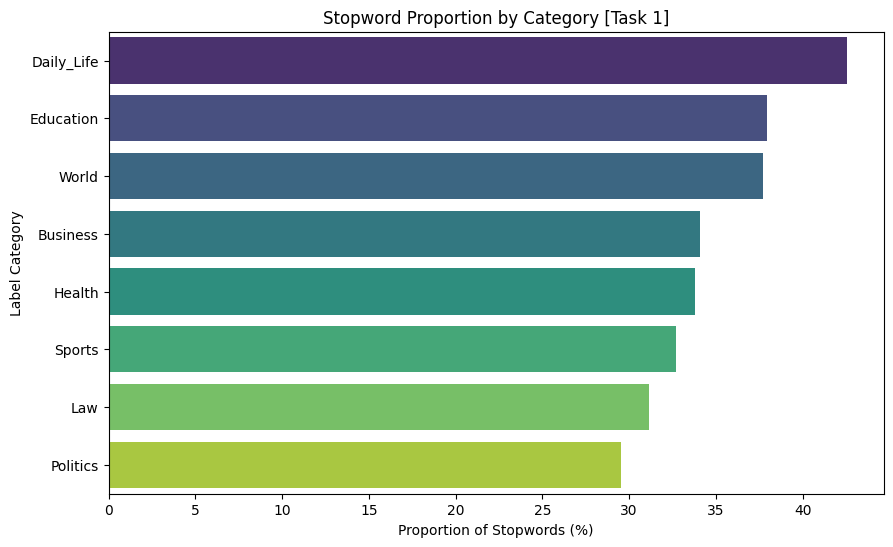

In [25]:
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Stopword Proportion (%)',
    y='Category',
    data=stats_df_task1.sort_values('Stopword Proportion (%)', ascending=False),
    palette='viridis'
)
plt.title('Stopword Proportion by Category [Task 1]')
plt.xlabel('Proportion of Stopwords (%)')
plt.ylabel('Label Category')
plt.savefig('plot/task1.png', dpi=300, bbox_inches='tight')
plt.show()

Saved plot to plot/task1_wordclouds_1-4.png


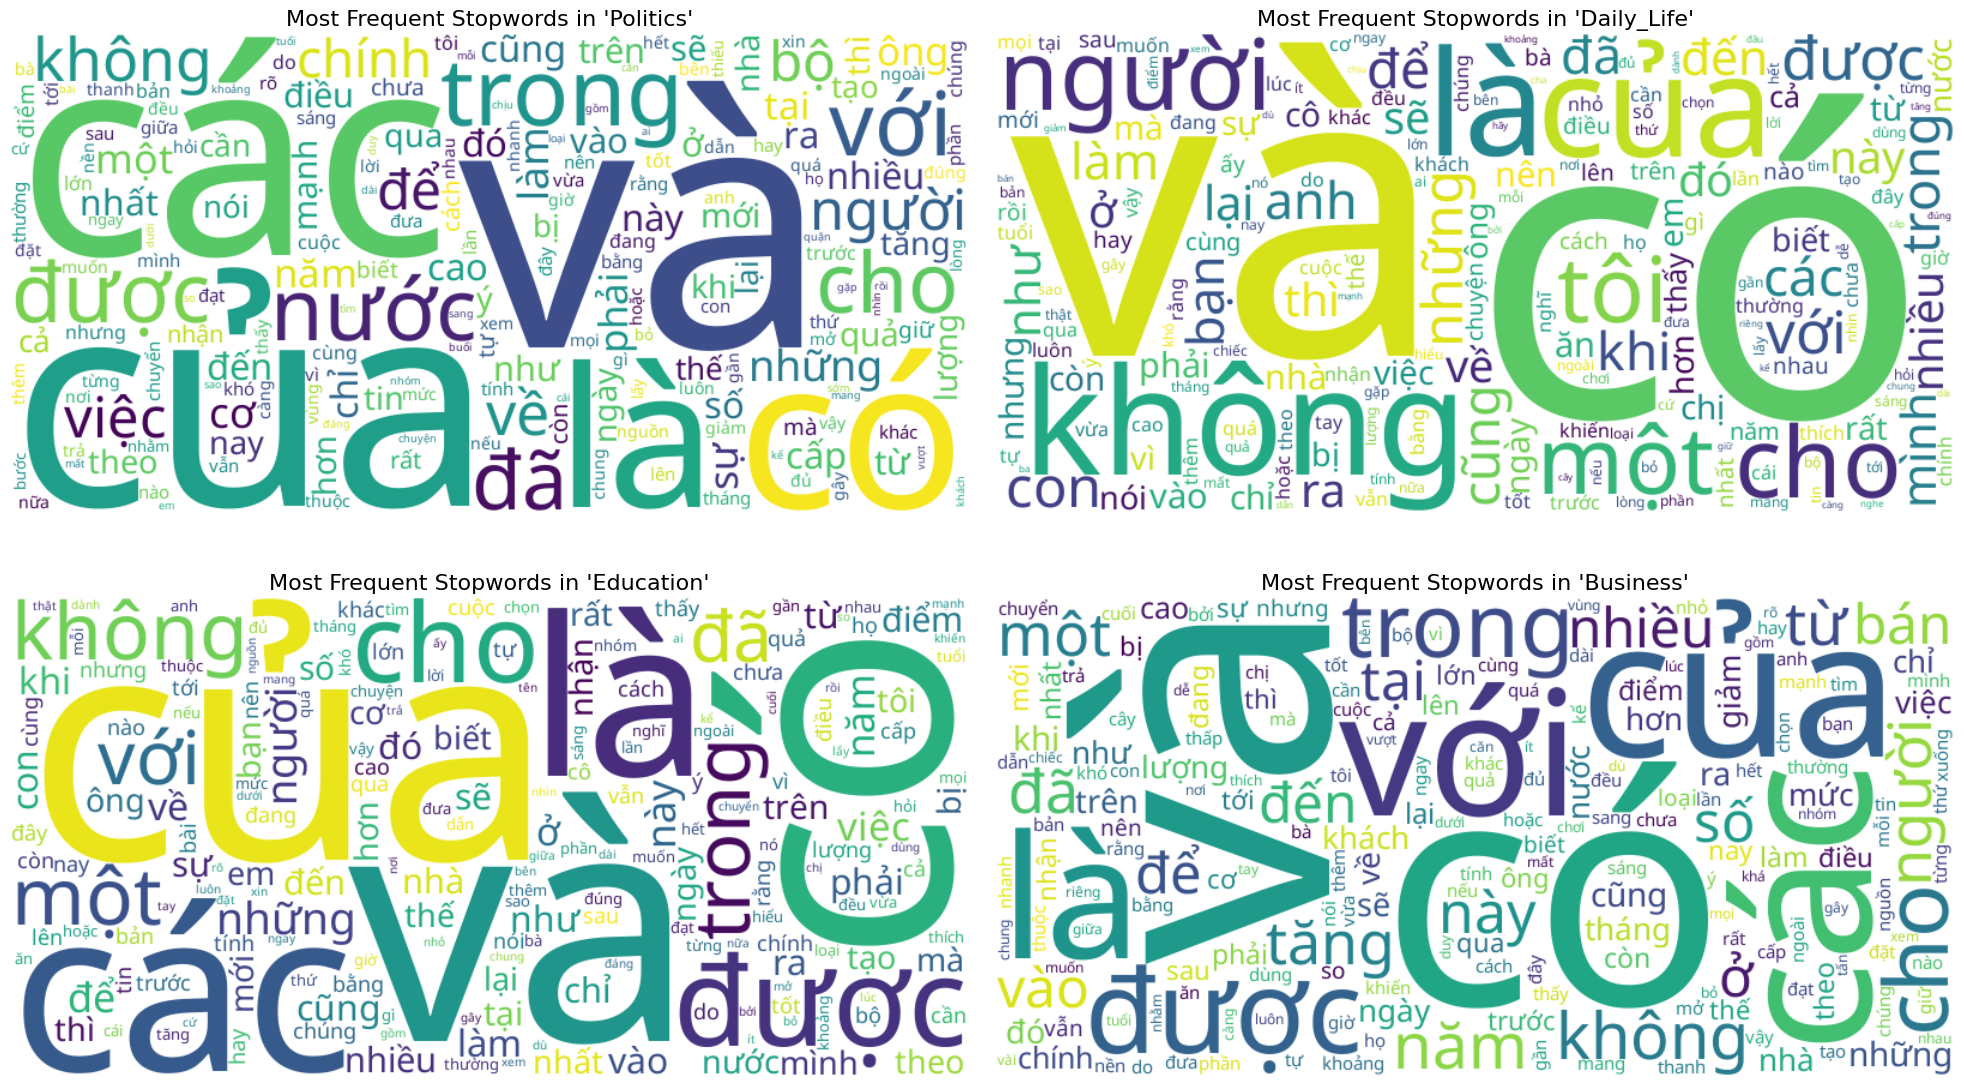


Generating Word Clouds for Categories 5-8...
Saved plot to plot/task1_wordclouds_5-8.png


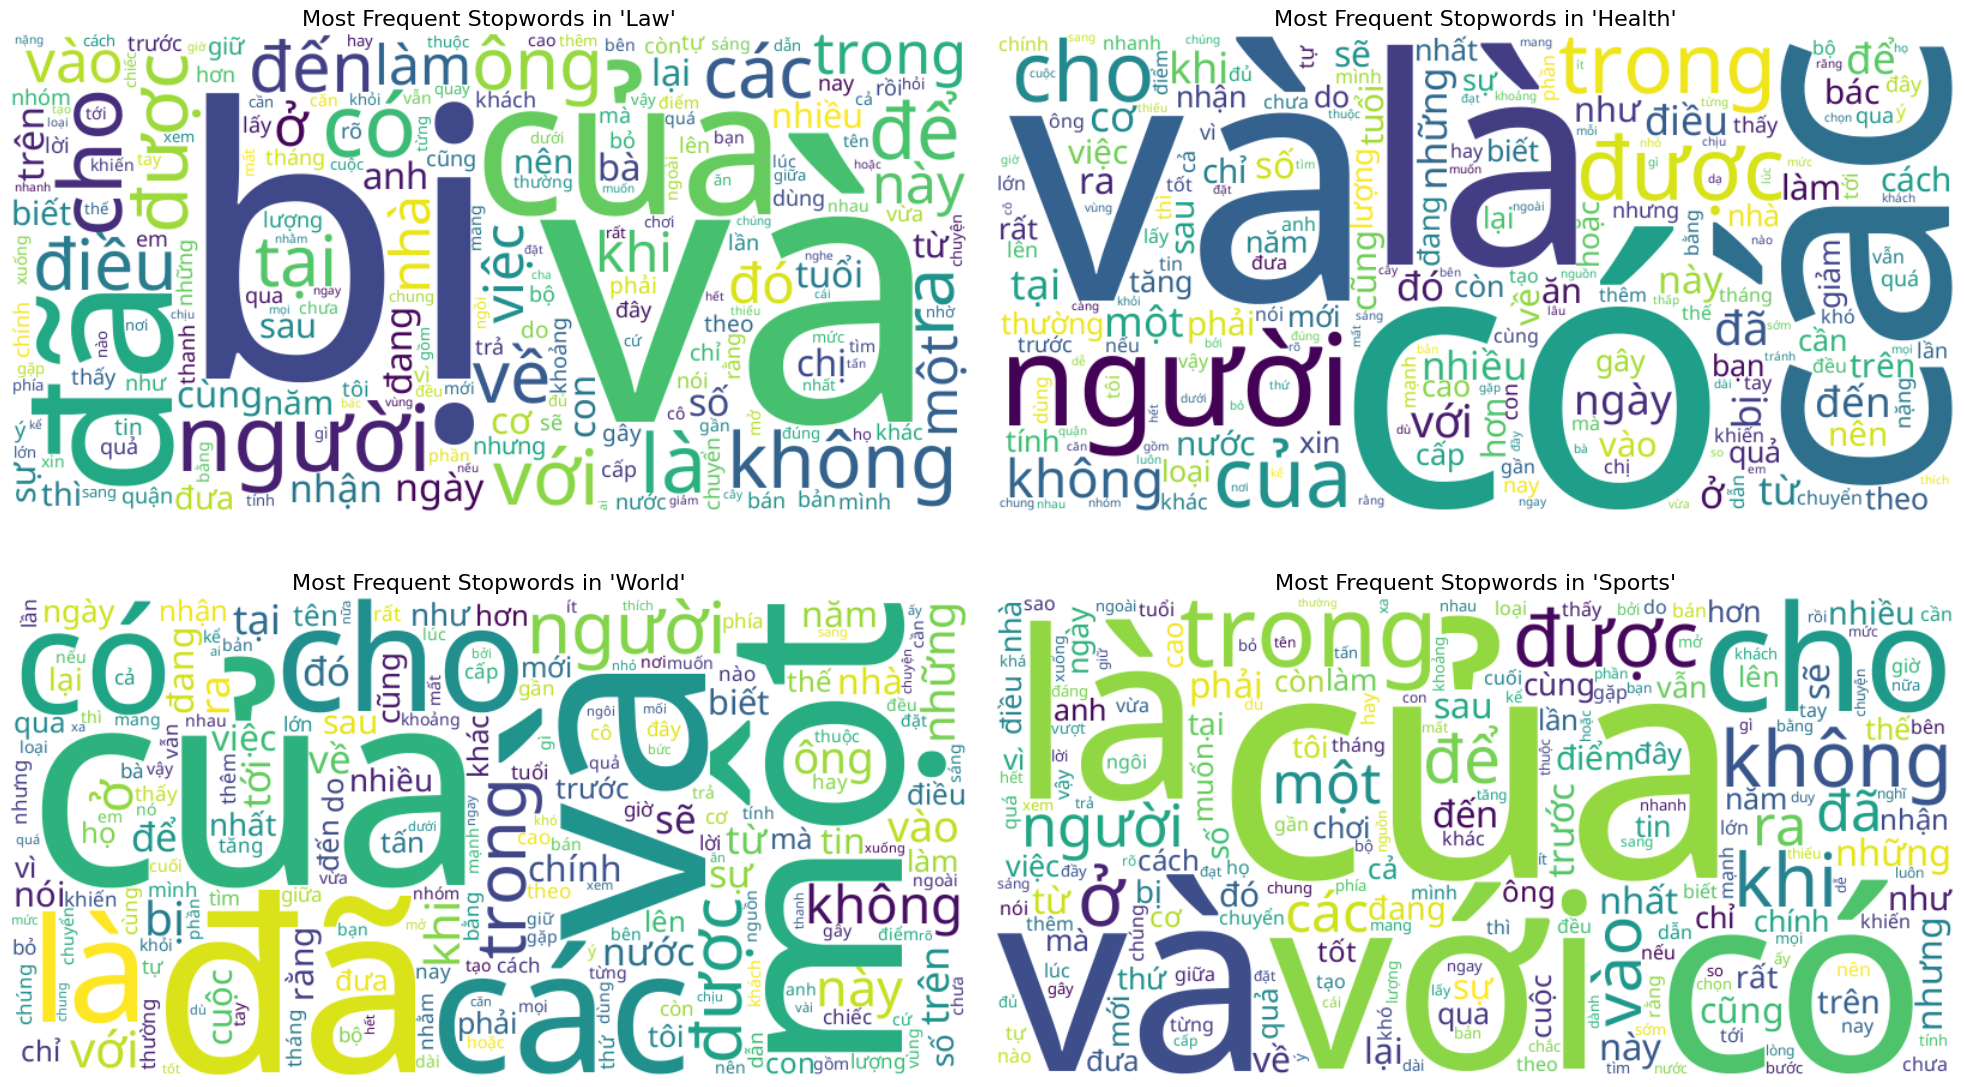

In [26]:

font_path = 'font/NotoSans-Regular.ttf' 

categories = list(stopword_freq_by_cat.keys())


#Categories 1-4

# Create a 2x2 grid of subplots
fig1, axes1 = plt.subplots(2, 2, figsize=(20, 12)) # (width, height) in inches
axes1_flat = axes1.flatten() 

# Loop through the first 4 categories
for i in range(4):
    if i >= len(categories):
        axes1_flat[i].axis('off')
        continue
        
    category = categories[i]
    freq_counter = stopword_freq_by_cat[category]
    ax = axes1_flat[i] 
    if not freq_counter:
        ax.set_title(f"No stopwords found for '{category}'")
        ax.axis('off')
        continue

    # Generate word cloud from frequencies
    wc = WordCloud(width=800, height=400, 
                   background_color='white',
                   collocations=False,
                   font_path=font_path # Use the specified font
                  ).generate_from_frequencies(freq_counter)
    
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f"Most Frequent Stopwords in '{category}'", fontsize=16)
    ax.axis("off")
    

plt.tight_layout(pad=2.0)
plot_path1 = os.path.join('plot/task1_wordclouds_1-4.png') 
plt.savefig(plot_path1, dpi=300, bbox_inches='tight')
print(f"Saved plot to {plot_path1}")
plt.show()


# categories 5-8
if len(categories) > 4: 
    print("\nGenerating Word Clouds for Categories 5-8...")

    fig2, axes2 = plt.subplots(2, 2, figsize=(20, 12))
    axes2_flat = axes2.flatten()

    # Loop through the next 4 categories
    for i in range(4):
        cat_index = i + 4 
        if cat_index >= len(categories):
            axes2_flat[i].axis('off') # Hide unused subplots
            continue
            
        category = categories[cat_index]
        freq_counter = stopword_freq_by_cat[category]
        ax = axes2_flat[i]
        
        if not freq_counter:
            ax.set_title(f"No stopwords found for '{category}'")
            ax.axis('off')
            continue

        # Generate word cloud
        wc = WordCloud(width=800, height=400, 
                       background_color='white',
                       collocations=False,
                       font_path=font_path
                      ).generate_from_frequencies(freq_counter)
        
        ax.imshow(wc, interpolation='bilinear')
        ax.set_title(f"Most Frequent Stopwords in '{category}'", fontsize=16)
        ax.axis("off")


        


    plt.tight_layout(pad=2.0)
    plot_path2 = os.path.join('plot/task1_wordclouds_5-8.png')
    plt.savefig(plot_path2, dpi=300, bbox_inches='tight')
    print(f"Saved plot to {plot_path2}")
    plt.show()

## Consistency (from Top 10 Tables)
The tables reveal which stopwords are the most frequent in each category. The most critical finding here is the high consistency across all topics:

- `và (and)` is in the Top 2 for 7 out of 8 categories.
  
- `của (of/belong to)` is in the Top 3 for 7 out of 8 categories.
  
- `có (have)` is in the Top 5 for 7 out of 8 categories.
  
- `là (to be)` is in the Top 5 for 7 out of 8 categories.

The same core group of 6-7 function words `(và, của, có, là, cho, các, được)` dominates the Top 10 list for almost every single topic.

## Proportions (from Bar Chart)

The bar chart shows two key things:

**High Frequency**: Stopwords make up a massive portion (30% to nearly 50%) of all words in every single category.

**Variance**: The proportion is not uniform. "Daily_Life" (doi-song) has the highest stopword rate (~45%), while "Politics" (chinh-tri) and "Law" (phap-luat) have the lowest (~30%).



## Conclussion

While the overall percentage of stopwords (from the bar chart) varies, the specific words that are most frequent (from the tables) are overwhelmingly the same across all categories.

This **strongly supports** the hypothesis that these core function words are non-discriminative. 

# Question 2: TF-IDF Statistics for Stopwords

In [27]:

from scipy.sparse import vstack


TASK2_TFIDF_PKL = os.path.join(PKL_FOLDER, 'task2.pkl')
stopword_vocab_list = sorted(list(vietnamese_stopwords_set))

if os.path.exists(TASK2_TFIDF_PKL):
    print(f"Loading cached Task 2 results from {TASK2_TFIDF_PKL}...")
    with open(TASK2_TFIDF_PKL, 'rb') as f:
        task2_data = pickle.load(f)
    tfidf_stats_df = task2_data['stats_df']
    stopword_tfidf_scores = task2_data['category_scores']
    categories = task2_data['categories']
    print("Results loaded.")

    
else:
    print("Cache not found. Running TF-IDF analysis...")

    def vn_extract(text):
        return str(text).split()

    categories = vn_df['label'].unique()
    stopword_tfidf_scores = {word: [] for word in stopword_vocab_list}

    # Vectorizer
    tfidf_vectorizer = TfidfVectorizer(
        tokenizer=vn_extract,
        vocabulary=stopword_vocab_list,
        lowercase=False,
        stop_words=None
    )

    all_matrices = []  # For corpus-level stats
    word_appeared = {word: False for word in stopword_vocab_list}  # Track which words appear

    for category in tqdm(categories):
        texts = vn_df[vn_df['label'] == category]['content'].tolist()
        if not texts:
            print(f"  Skipping empty category '{category}'")
            for word in stopword_vocab_list:
                stopword_tfidf_scores[word].append(0.0)
            continue

        try:
            tfidf_matrix = tfidf_vectorizer.fit_transform(texts)
            all_matrices.append(tfidf_matrix)

            # Sparse-safe average per stopword
            avg_scores = tfidf_matrix.mean(axis=0).A1  # convert to 1D array
            for i, word in enumerate(stopword_vocab_list):
                stopword_tfidf_scores[word].append(avg_scores[i])
                if avg_scores[i] > 0:
                    word_appeared[word] = True

        except ValueError as e:
            print(f"  Error in category '{category}': {e}")
            for word in stopword_vocab_list:
                stopword_tfidf_scores[word].append(0.0)

    print("\nCalculating TF-IDF statistics across all documents...")
    if all_matrices:
        full_matrix = vstack(all_matrices)
        avgs = full_matrix.mean(axis=0).A1
        stds = np.std(full_matrix.toarray(), axis=0)
        maxs = full_matrix.max(axis=0).toarray().ravel()
        mins = full_matrix.min(axis=0).toarray().ravel()
    else:
        avgs = [0.0]*len(stopword_vocab_list)
        stds = [0.0]*len(stopword_vocab_list)
        maxs = [0.0]*len(stopword_vocab_list)
        mins = [0.0]*len(stopword_vocab_list)

    # Assign -1 for words that never appeared
    for i, word in enumerate(stopword_vocab_list):
        if not word_appeared[word]:
            avgs[i] = stds[i] = maxs[i] = mins[i] = -1

    tfidf_stats_df = pd.DataFrame({
        'Stopword': stopword_vocab_list,
        'Average TF-IDF': avgs,
        'Std Dev TF-IDF': stds,
        'Max TF-IDF': maxs,
        'Min TF-IDF': mins
    })

    # Save results
    task2_data = {
        'stats_df': tfidf_stats_df,
        'category_scores': stopword_tfidf_scores,
        'categories': categories
    }
    with open(TASK2_TFIDF_PKL, 'wb') as f:
        pickle.dump(task2_data, f)

    print(f"TF-IDF analysis complete. Results saved to {TASK2_TFIDF_PKL}")


Loading cached Task 2 results from pkl_folder\task2.pkl...
Results loaded.


In [28]:

# Keep only stopwords that actually appeared (Average TF-IDF >= 0)
tfidf_stats_df_new = tfidf_stats_df[tfidf_stats_df['Average TF-IDF'] >= 0].copy()

# reset the index
tfidf_stats_df_new.reset_index(drop=True, inplace=True)

print(f"Removed {len(tfidf_stats_df) - len(tfidf_stats_df_new)} stopwords that never appeared.")


tfidf_stats_df_sorted = tfidf_stats_df_new.sort_values('Average TF-IDF')

# Get lowest 15, highest 15 
lowest_15_df = tfidf_stats_df_sorted.head(15).copy()
highest_15_df = tfidf_stats_df_sorted.tail(15).copy() 


print("\nTranslating top/bottom stopwords...")

lowest_15_df['Translation'] = translate_words(lowest_15_df['Stopword'].tolist())
highest_15_df['Translation'] = translate_words(highest_15_df['Stopword'].tolist())


print("\nTF-IDF Stats (Lowest 15 Avg TF-IDF with Translation)") 
print(lowest_15_df[['Stopword', 'Translation', 'Average TF-IDF', 'Min TF-IDF', 'Max TF-IDF']].to_markdown(index=False, floatfmt=".4f"))
print("\nTF-IDF Stats (Highest 15 Avg TF-IDF with Translation)")
print(highest_15_df[['Stopword', 'Translation', 'Average TF-IDF', 'Min TF-IDF', 'Max TF-IDF']].to_markdown(index=False, floatfmt=".4f"))


print("\nComment on Analysis:")
num_valid = tfidf_stats_df[
    (tfidf_stats_df['Average TF-IDF'] >= 0) & 
    (tfidf_stats_df['Average TF-IDF'] < 0.05)
].shape[0]

print(f"{num_valid} out of {len(tfidf_stats_df)} stopwords have average TF-IDF < 0.05.")




Removed 1593 stopwords that never appeared.

Translating top/bottom stopwords...

TF-IDF Stats (Lowest 15 Avg TF-IDF with Translation)
| Stopword   | Translation   |   Average TF-IDF |   Min TF-IDF |   Max TF-IDF |
|:-----------|:--------------|-----------------:|-------------:|-------------:|
| rày        | Hey           |           0.0000 |       0.0000 |       0.0601 |
| nớ         | no            |           0.0000 |       0.0000 |       0.0619 |
| xoẹt       | swish         |           0.0000 |       0.0000 |       0.0673 |
| úi         | Ugh           |           0.0000 |       0.0000 |       0.1114 |
| béng       | baby          |           0.0000 |       0.0000 |       0.0713 |
| phóc       | phoc          |           0.0000 |       0.0000 |       0.1634 |
| alô        | Hello         |           0.0000 |       0.0000 |       0.1269 |
| phụt       | Phew          |           0.0000 |       0.0000 |       0.1116 |
| rứa        | rye           |           0.0000 |       0.0000 | 

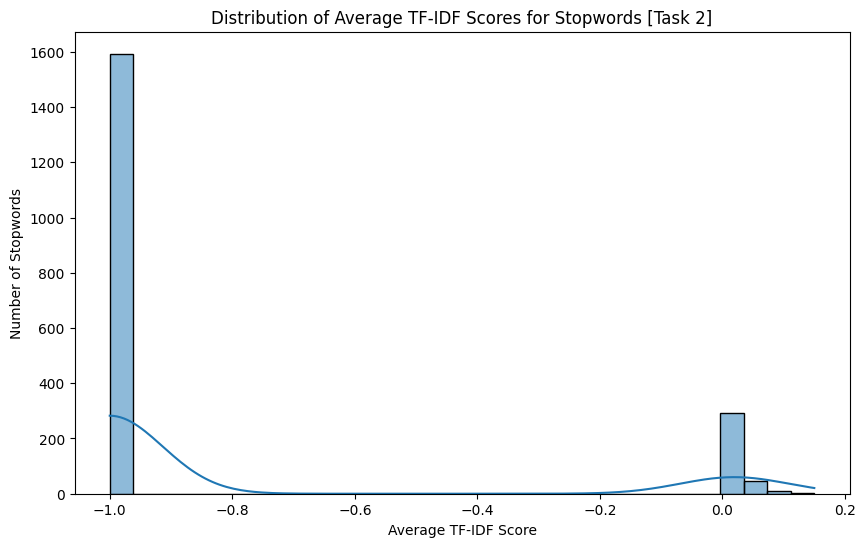

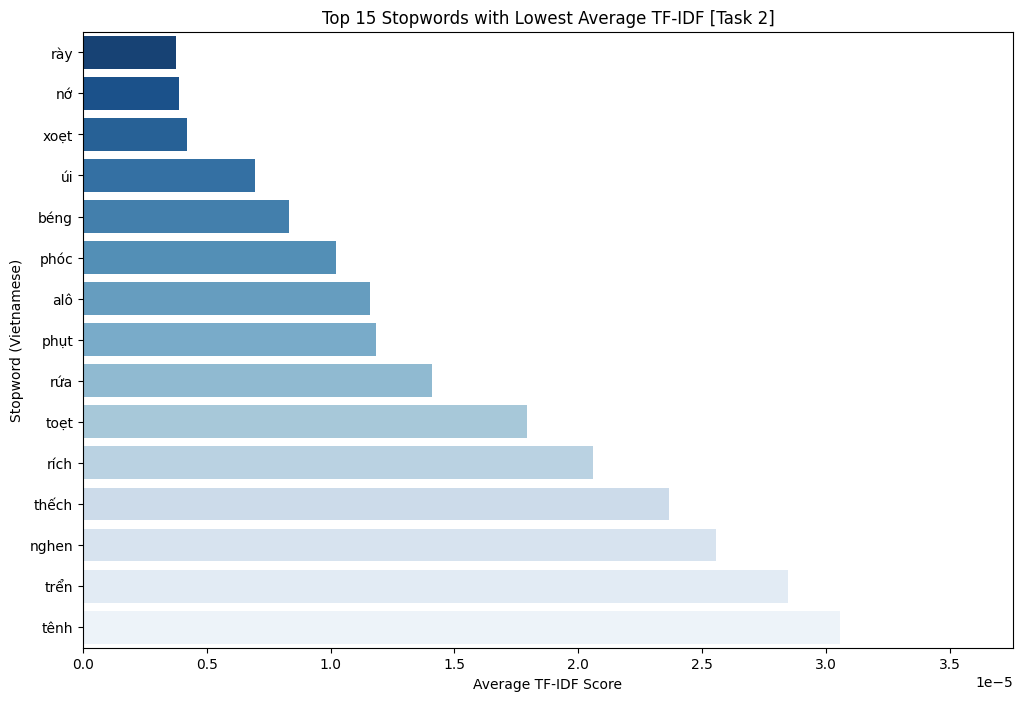

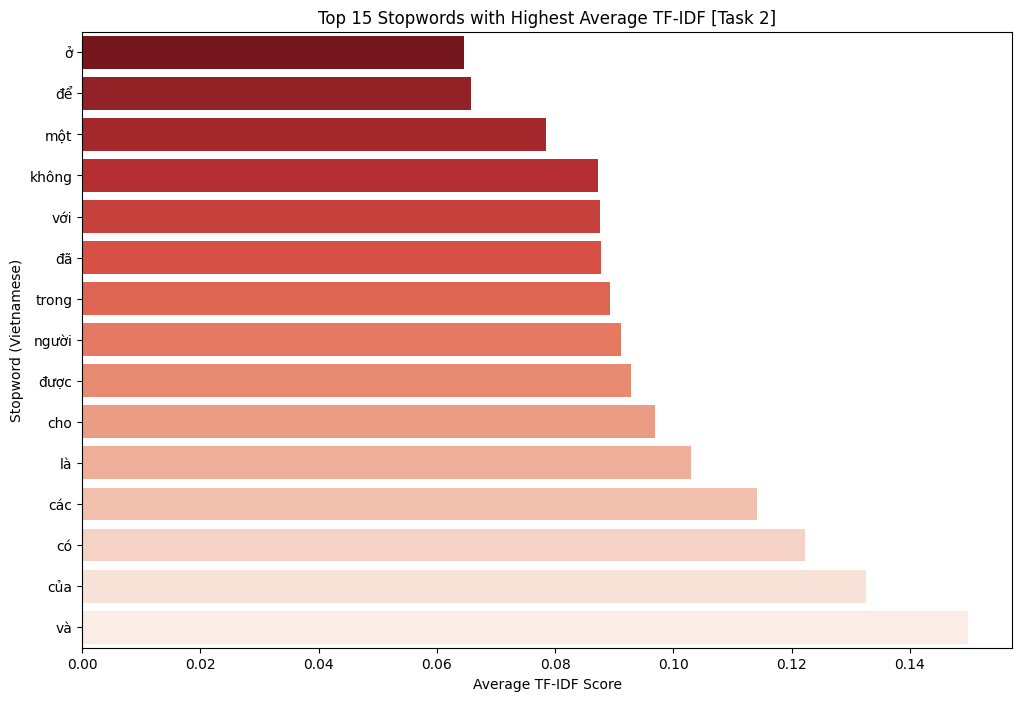

In [29]:
plt.figure(figsize=(10, 6)) 
sns.histplot(tfidf_stats_df['Average TF-IDF'], bins=30, kde=True)
plt.title('Distribution of Average TF-IDF Scores for Stopwords [Task 2]')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Number of Stopwords')

plt.savefig('plot/task2_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='Average TF-IDF', y='Stopword', data=lowest_15_df, palette='Blues_r')
plt.title('Top 15 Stopwords with Lowest Average TF-IDF [Task 2]') 
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Stopword (Vietnamese)')
min_non_zero = tfidf_stats_df[tfidf_stats_df['Average TF-IDF'] > 0]['Average TF-IDF'].min()
if not pd.isna(min_non_zero) and lowest_15_df['Average TF-IDF'].max() < min_non_zero * 10:
     plt.xlim(right=min_non_zero * 10) 

plt.savefig('plot/task2_bottom15.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='Average TF-IDF', y='Stopword', data=highest_15_df, palette='Reds_r')
plt.title('Top 15 Stopwords with Highest Average TF-IDF [Task 2]')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Stopword (Vietnamese)')

plt.savefig('plot/task2_top15.png', dpi=300, bbox_inches='tight')
plt.show()



## Findings

We evaluated a predefined Vietnamese stopword list across 8 text categories using TF-IDF without stopword removal.

Key steps:
- Built per-category vocabularies and TF-IDF matrices
- Computed the average TF-IDF for each stopword across all categories
- Removed `1,593` stopwords (out of 1,942) that never appeared
- Analyzed the remaining `349` stopwords

Distribution observations:
- The majority of stopwords cluster tightly near zero TF-IDF, matching expected **non-informative** behavior
- A distinct minority cluster shows higher TF-IDF, indicating discriminative value in specific categories

Quantitative summary:
- 319 out of 1,942 stopwords (~16%) have average TF-IDF < 0.05
- Several classic stopwords rank among the top TF-IDF terms (`và`, `của`, `là`, `người`, `được`)
- Example: `người` ranges from 0.0000 to 0.8766, acting as noise in some categories but highly informative in others

Visual Evidence:
- Distribution plot shows heavily skewed density at 0 with a tail of high-value terms
- Bar charts highlight lowest-TF-IDF "ideal" stopwords vs. highest-TF-IDF highly informative stopwords

## Conclusion

Our results suggest **Pareto-like pattern**: only a small fraction of stopwords (~20%) behave as true stopwords, while the majority contain discriminative information and should not be removed blindly. Although most words behave as stopwords, a meaningful subset of common function words are strongly category-discriminative. Removing them would degrade model performance and eliminate critical semantic signals. Stopword filtering must be **data and category specific**, rather than relying on a universal static stopword list.


# Question 3: Identify Top 100 TF-IDF Stopwords & Compare

In [30]:

def get_stopword_candidates_step3(tfidf_stats_df: pd.DataFrame, 
                                  stopword_all_category_scores: dict, 
                                  top_n: int = 100) -> list[tuple[str, float, int]]:
    """
    Identifies stopword candidates based on TF-IDF statistics.
    """
    print(f"Generating stopword candidates for Step 3 (top {top_n})...")

    data = []
    for index, row in tfidf_stats_df.iterrows():
        word = row['Stopword']
        
        if word in stopword_all_category_scores and stopword_all_category_scores[word]:
             avg_score = np.mean(stopword_all_category_scores[word])
             ncategories = sum(1 for score in stopword_all_category_scores[word] if score > 1e-9)
        else:
             avg_score = 0.0
             ncategories = 0 

        data.append((word, avg_score, ncategories))

    # Sort: 1. By ncategories (descending), 2. By avg_score (ascending)
    data.sort(key=lambda e: (-e[2], e[1]))

    print("Stopword candidates generated and sorted.")
    return data[:top_n]



if 'tfidf_stats_df' in locals() and 'stopword_tfidf_scores' in locals():
    
    stopword_candidates = get_stopword_candidates_step3(
        tfidf_stats_df, 
        stopword_tfidf_scores,
        top_n=100
    )

    # Get the top 10 candidates
    top_10_candidates = stopword_candidates[:10]

    # Extract just the words into a list
    words_to_translate = [word for word, _, _ in top_10_candidates]

    try:
        translated_words = translate_words(words_to_translate)
    except Exception as e:
        print(f"Error during translation: {e}. Defaulting to 'Error'.")
        translated_words = ["Error"] * 10 # Create a list of "Error" placeholders


    for i, (word, avg_score, ncategories) in enumerate(top_10_candidates):
        translation = translated_words[i] # Get the translation from our list
        
        print(f"{i+1:>2}. Word (VI): {word:<12} | Word (EN): {translation:<15} | Avg TF-IDF: {avg_score:.4f} | Categories: {ncategories}")


else:
    print("Error: 'tfidf_stats_df' or 'stopword_tfidf_scores' not found.")
    print("Please ensure the new Task 2 cell was executed successfully.")

Generating stopword candidates for Step 3 (top 100)...
Stopword candidates generated and sorted.
 1. Word (VI): thỏm         | Word (EN): bored           | Avg TF-IDF: 0.0002 | Categories: 8
 2. Word (VI): chợt         | Word (EN): suddenly        | Avg TF-IDF: 0.0003 | Categories: 8
 3. Word (VI): nhỉ          | Word (EN): right?          | Avg TF-IDF: 0.0004 | Categories: 8
 4. Word (VI): thà          | Word (EN): rather          | Avg TF-IDF: 0.0005 | Categories: 8
 5. Word (VI): nọ           | Word (EN): that            | Avg TF-IDF: 0.0005 | Categories: 8
 6. Word (VI): nấy          | Word (EN): whatever        | Avg TF-IDF: 0.0006 | Categories: 8
 7. Word (VI): á            | Word (EN): ah              | Avg TF-IDF: 0.0006 | Categories: 8
 8. Word (VI): à            | Word (EN): ah              | Avg TF-IDF: 0.0006 | Categories: 8
 9. Word (VI): ồ            | Word (EN): Oh              | Avg TF-IDF: 0.0006 | Categories: 8
10. Word (VI): thốt         | Word (EN): exclaimed       

In [31]:

if ('tfidf_stats_df' not in locals() or 
    'stopword_tfidf_scores' not in locals() or 
    'categories' not in locals() or
    'vietnamese_stopwords_set' not in locals()):
    
    print("Error: Required variables from Task 2 are not found.")
    print("Please ensure the new Task 2 cell was executed successfully.")

else:
    # thresholds to test
    thresholds = [0.001, 0.005, 0.01, 0.02]
    overlap_results = []
    
    analysis_df = tfidf_stats_df.copy()
    num_categories = len(categories)

    for t in thresholds:
        print(f"\nProcessing threshold = {t}...")

        analysis_df['Low_Score_Count'] = analysis_df['Stopword'].apply(
            lambda w: sum([s < t for s in stopword_tfidf_scores[w]])
        )
        analysis_df['Low_Score_Ratio'] = analysis_df['Low_Score_Count'] / num_categories

        analysis_df_sorted = analysis_df.sort_values(
            ['Low_Score_Ratio', 'Average TF-IDF'],
            ascending=[False, True]
        )

        top_100_set = set(analysis_df_sorted.head(100)['Stopword'])
        common = top_100_set.intersection(vietnamese_stopwords_set)
        overlap_percentage = (len(common) / 100) * 100 

        print(f"Top 100 stopwords identified for threshold {t}.")
        print(f"Overlap with default list: {len(common)} words ({overlap_percentage:.2f}%)")

        overlap_results.append({
            'Threshold': t,
            'Top 100 Size': len(top_100_set),
            'Common Words': len(common),
            'Overlap %': overlap_percentage
        })



Processing threshold = 0.001...
Top 100 stopwords identified for threshold 0.001.
Overlap with default list: 100 words (100.00%)

Processing threshold = 0.005...
Top 100 stopwords identified for threshold 0.005.
Overlap with default list: 100 words (100.00%)

Processing threshold = 0.01...
Top 100 stopwords identified for threshold 0.01.
Overlap with default list: 100 words (100.00%)

Processing threshold = 0.02...
Top 100 stopwords identified for threshold 0.02.
Overlap with default list: 100 words (100.00%)


### Findings


1. **Top 100 stopwords** were identified for each threshold.
   
2. For **all thresholds**, the **overlap with the default Vietnamese stopword list was 100%**, meaning every stopword identified by TF-IDF also exists in the standard list.
   
#### Interpretation

- These words have **low discriminative power** for distinguishing documents in different categories, which is exactly what we expect from stopwords.
  
- The thresholds used (0.001 → 0.02) did not change the results, suggesting that these words are **extremely consistent in frequency** and TF-IDF magnitude across the corpus.
  
- The TF-IDF-based selection method **confirms the validity of the default stopword list** for Vietnamese in information retrieval tasks.

#### Conclusion

This analysis support the theory that using **TF-IDF to identify stopwords** is effective and aligns with linguistic intuition. Words that appear across many documents with high frequency naturally receive low TF-IDF scores, making them ideal candidates for exclusion in retrieval or text processing tasks. 


# Question 4: Identify stopwords (>= 50% category)

In [32]:
TASK4_ZERO_TFIDF_PKL = os.path.join(PKL_FOLDER, 'task4.pkl')
TASK2_TFIDF_PKL = os.path.join(PKL_FOLDER, 'task2.pkl')


if os.path.exists(TASK4_ZERO_TFIDF_PKL):
    print(f"Loading cached Task 4 results from {TASK4_ZERO_TFIDF_PKL}...")
    with open(TASK4_ZERO_TFIDF_PKL, 'rb') as f:
        cached_data = pickle.load(f)
        zero_tfidf_stopwords_list = cached_data['zero_tfidf_list']
        stopword_zero_counts = cached_data['zero_counts']
        threshold_categories = cached_data['threshold_categories']
        valid_stopwords = cached_data['valid_stopwords']
    print(f"Task 4 results loaded. Total stopwords meeting criteria: {len(zero_tfidf_stopwords_list)}")

else:
    print("Cache not found for Task 4. Running analysis using Task 2 results...")
    if not os.path.exists(TASK2_TFIDF_PKL):
        raise FileNotFoundError("Task-2 results file not found. Run Task-2 first.")

    with open(TASK2_TFIDF_PKL, 'rb') as f:
        task2_data = pickle.load(f)

    stopword_tfidf_scores = task2_data['category_scores']
    tfidf_stats_df = task2_data['stats_df']
    categories = list(task2_data['categories'])
    num_categories = len(categories)
    threshold_categories = int(np.ceil(num_categories / 2.0))

    print(f"Total categories = {num_categories} | Zero-threshold = {threshold_categories}")

    # Filter ONLY stopwords that actually appeared: avg >= 0
    tfidf_stats_df_filtered = tfidf_stats_df[tfidf_stats_df['Average TF-IDF'] >= 0]
    valid_stopwords = set(tfidf_stats_df_filtered['Stopword'])

    print(f"Filtering from {len(tfidf_stats_df)} stopwords → {len(valid_stopwords)} appeared in corpus")


    zero_tfidf_stopwords_list = []
    stopword_zero_counts = {}

    for stopword in tqdm(valid_stopwords, desc="Scanning TF-IDF scores"):
        scores = stopword_tfidf_scores[stopword]  # list per category
        zero_count = sum(1 for s in scores if s < 1e-6)
        stopword_zero_counts[stopword] = zero_count

        if zero_count >= threshold_categories:
            zero_tfidf_stopwords_list.append(stopword)

    results_to_save = {
        'zero_tfidf_list': zero_tfidf_stopwords_list,
        'zero_counts': stopword_zero_counts,
        'threshold_categories': threshold_categories,
        'valid_stopwords' : valid_stopwords
    }

    with open(TASK4_ZERO_TFIDF_PKL, 'wb') as f:
        pickle.dump(results_to_save, f)

    print(f"Task-4 complete. Total stopwords meeting criteria: {len(zero_tfidf_stopwords_list)}")

print(f"\nStopwords with TF-IDF zero in >= 50% categories: {len(zero_tfidf_stopwords_list)}")
print("Examples:", sorted(zero_tfidf_stopwords_list)[:20])


Loading cached Task 4 results from pkl_folder\task4.pkl...
Task 4 results loaded. Total stopwords meeting criteria: 29

Stopwords with TF-IDF zero in >= 50% categories: 29
Examples: ['alô', 'béng', 'bớ', 'mợ', 'nghen', 'nghỉm', 'nớ', 'phóc', 'phắt', 'phụt', 'rày', 'rén', 'rích', 'rứa', 'sì', 'thím', 'thếch', 'thốc', 'toẹt', 'trển']


In [33]:
# Compare with default Vietnamese stopword list
zero_tfidf_stopwords_set = set(zero_tfidf_stopwords_list)
common_stopwords_task4 = zero_tfidf_stopwords_set.intersection(vietnamese_stopwords_set)

print(f"\nStopwords with TF-IDF Zero in >= {threshold_categories:.0f} categories")
print(f"Original Vietnamese stopword list size: {len(vietnamese_stopwords_set)}")
print(f"Original used Vietnamese stopword list size: {len(valid_stopwords)}")
print(f"Zero TF-IDF stopwords in >= 50% category: {len(zero_tfidf_stopwords_set)}")
print(f"\nOverlap with default list: ({len(common_stopwords_task4)/len(vietnamese_stopwords_set)*100:.2f}%)")

print(f"Overlap with used default list: ({len(common_stopwords_task4)/len(valid_stopwords)*100:.2f}%)")




Stopwords with TF-IDF Zero in >= 4 categories
Original Vietnamese stopword list size: 1942
Original used Vietnamese stopword list size: 349
Zero TF-IDF stopwords in >= 50% category: 29

Overlap with default list: (1.49%)
Overlap with used default list: (8.31%)


In [34]:

top_zero_tfidf = sorted(zero_tfidf_stopwords_list, key=lambda w: -stopword_zero_counts[w])


print("\nTop zero-TFIDF stopwords with translation:")
print(top_zero_tfidf)



Top zero-TFIDF stopwords with translation:
['rứa', 'úi', 'rày', 'nớ', 'phóc', 'béng', 'xoẹt', 'thếch', 'rén', 'mợ', 'thốc', 'phụt', 'ừ', 'tênh', 'alô', 'toẹt', 'trển', 'nghen', 'ổng', 'tắp', 'sì', 'ờ', 'rích', 'thím', 'bớ', 'phắt', 'xuể', 'vèo', 'nghỉm']




## Findings:

The 29 words that met this strict criterion `(nớ, phóc, úi, thếch, béng, rày, xoẹt)` are not common function words. They are primarily extremely rare, dialectal, or archaic terms

This result shows that most common NLTK stopwords (like ` và, của, là`) are too ubiquitous to have a zero TF-IDF score. They appear at least once in almost all 8 categories, making it impossible for them to meet the 50% zero-score threshold.

Therefore, this "zero TF-IDF" method  **is not** an effective way to identify the most important or frequent stopwords in this corpus; it only identifies the most obscure ones. This highlights a key limitation of using a strict zero-score criterion for stopword identification.